# Fits by Band - with Chi Squared plotted underneath

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sncosmo
from bayesn import SEDmodel
import os
import pandas as pd
import pickle

## Load model

In [2]:
filter_yaml = "/root/partiiiproject/bayesn-filters/bayesn-filters/filters.yaml"
model = SEDmodel(load_model='W22_model', filter_yaml = filter_yaml)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


Current devices: [CpuDevice(id=0), CpuDevice(id=1), CpuDevice(id=2), CpuDevice(id=3)]
Currently working in /root/partiiiproject
Loading built-in model W22_model
Loading built-in reddening law F99


## Choose which SN to look at and which dust laws

In [11]:
supernova_name = "sn2005A"
dust_laws = ["F19", "G23", "F99"]
supernova_file = "/root/partiiiproject/Archive/"+supernova_name+".dat"

## Load observational data

In [12]:
#Get SN info from the original data file
meta, lcdata = sncosmo.read_snana_ascii(supernova_file, default_tablename='OBS')
lcdata = lcdata['OBS'].to_pandas()

#Extract useful properties from data file used in fits and simulation
bands = np.unique(lcdata['FLT'])
z = meta['REDSHIFT_FINAL']
ebv_mw = meta['MWEBV']
    
#Get the observed times covered by the model, so in range [-10,40]
t_obs = lcdata['MJD'] - meta['SEARCH_PEAKMJD']
t_obs = t_obs[(-10<=t_obs) & (t_obs<=40)]
t_obs = np.unique(t_obs)

## Calculate the Chi squared statistic for each value

In [13]:
#Have Chi Squared a 3D matrix
methods = ["fit"]
chi_squared = np.zeros(len(lcdata)*len(dust_laws)*len(methods))
chi_squared =np.reshape(chi_squared, [len(lcdata),len(dust_laws),len(methods)])

method_dust = ["simF99","simG23","simF19","fitF99","fitG23","fitF19"]
fluxesdf = pd.DataFrame(columns = bands, index = method_dust)


for method in methods:
    method_index = methods.index(method)
    #Repeat through each dust law for that SN
    for dust_law in dust_laws:
        dust_law_index = dust_laws.index(dust_law)
        #Define directory where we should have our fits saved
        try:
            sampleChainsDir = "DustLawsFitOfAllSamples/"+supernova_name + dust_law + "_chains.pkl"
            sampleSummaryDir = "DustLawsFitOfAllSamples/"+supernova_name + dust_law + "_fit_summary.csv"

        except FileNotFoundError:
            continue
        #Check we have generated fits for this SN, otherwise move onto next SN
        try:
            #Load the chains with pickle
            with open(sampleChainsDir, 'rb') as file:
                chains = pickle.load(file)
        except FileNotFoundError:
            continue

        if method == "sim":
            #Number of simulations to load
            N=1
            #Get values for simulation directly from chains, taking the mean
            fit_mu = np.mean(chains['mu'])
            fit_theta = np.mean(chains['theta'])
            fit_RV = np.mean(chains['RV'])
            fit_AV = np.mean(chains['AV'])
            fit_tmax = np.mean(chains['tmax'])
            fit_delM = np.mean(chains['delM'])
            
            #For epsilon we need some reshaping to get it in the correct form
            fit_eps_inner = chains['eps']
            fit_eps_inner = np.reshape(fit_eps_inner, (4, 250, 9, 6), order='F')
            fit_eps = np.zeros((4, 250, 11, 6))
            fit_eps[:,:,1:-1,:] = fit_eps_inner
            fit_eps = fit_eps.mean(axis = 1)
            fit_eps = fit_eps.mean(axis = 0)
            fit_eps = np.reshape(fit_eps, (1 , 11, 6))

            #Run simulation and get flux values
            try:
                sim = model.simulate_light_curve(t_obs, N, bands, mu=fit_mu, theta=fit_theta,  z=z, ebv_mw=ebv_mw, mag=False, write_to_files=False, AV=fit_AV, RV=fit_RV, redlaw=dust_law, tmax=fit_tmax, eps=fit_eps)
            except ValueError:
                continue
            flux, flux_err, params = sim
            flux = np.reshape(flux,(len(bands),len(t_obs)))

        if method == "fit":
            #Use get flux from chains to get the best fit
            try:
                flux_grid = model.get_flux_from_chains(t_obs, bands, sampleChainsDir, z, ebv_mw, mag=False, num_samples=10)
                flux, flux_err = flux_grid.mean(axis=(0, 1)), flux_grid.std(axis=(0, 1))
            except ValueError:
                continue
        
        for i, entry in lcdata.iterrows():
            #Check the time is in the range the model covers
            if (entry.MJD-meta['SEARCH_PEAKMJD'] in t_obs) == False:
                continue
            #Ignore U bands
            if entry.FLT in ['u_CSP', 'U']:
                continue
            #Find the location of the flux we want
            index_t_obs = np.where(t_obs == (entry.MJD-meta['SEARCH_PEAKMJD']))
            index_band = np.where(bands == entry.FLT)
            #Calculate the chisquared statistic at that observation
            Exp = flux[index_band, index_t_obs]
            Exp = Exp[0]
            Obs = entry.FLUXCAL
            ObsErr = entry.FLUXCALERR
            chi_squared_calc = ((Obs-Exp)**2)/(ObsErr**2)
            #Update entry for chi squared in the correct position
            if chi_squared_calc.size != 0:
                chi_squared[i, dust_law_index, method_index] = chi_squared_calc[0]
            
            for band in bands:
                band_index = np.where(bands==band)
                fluxesdf.at[method+dust_law, band] = flux[band_index,:]
            
              

Getting best fit light curves from chains...


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.42s/it]


Getting best fit light curves from chains...


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.41it/s]


Getting best fit light curves from chains...


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.03it/s]


## Plot graphs

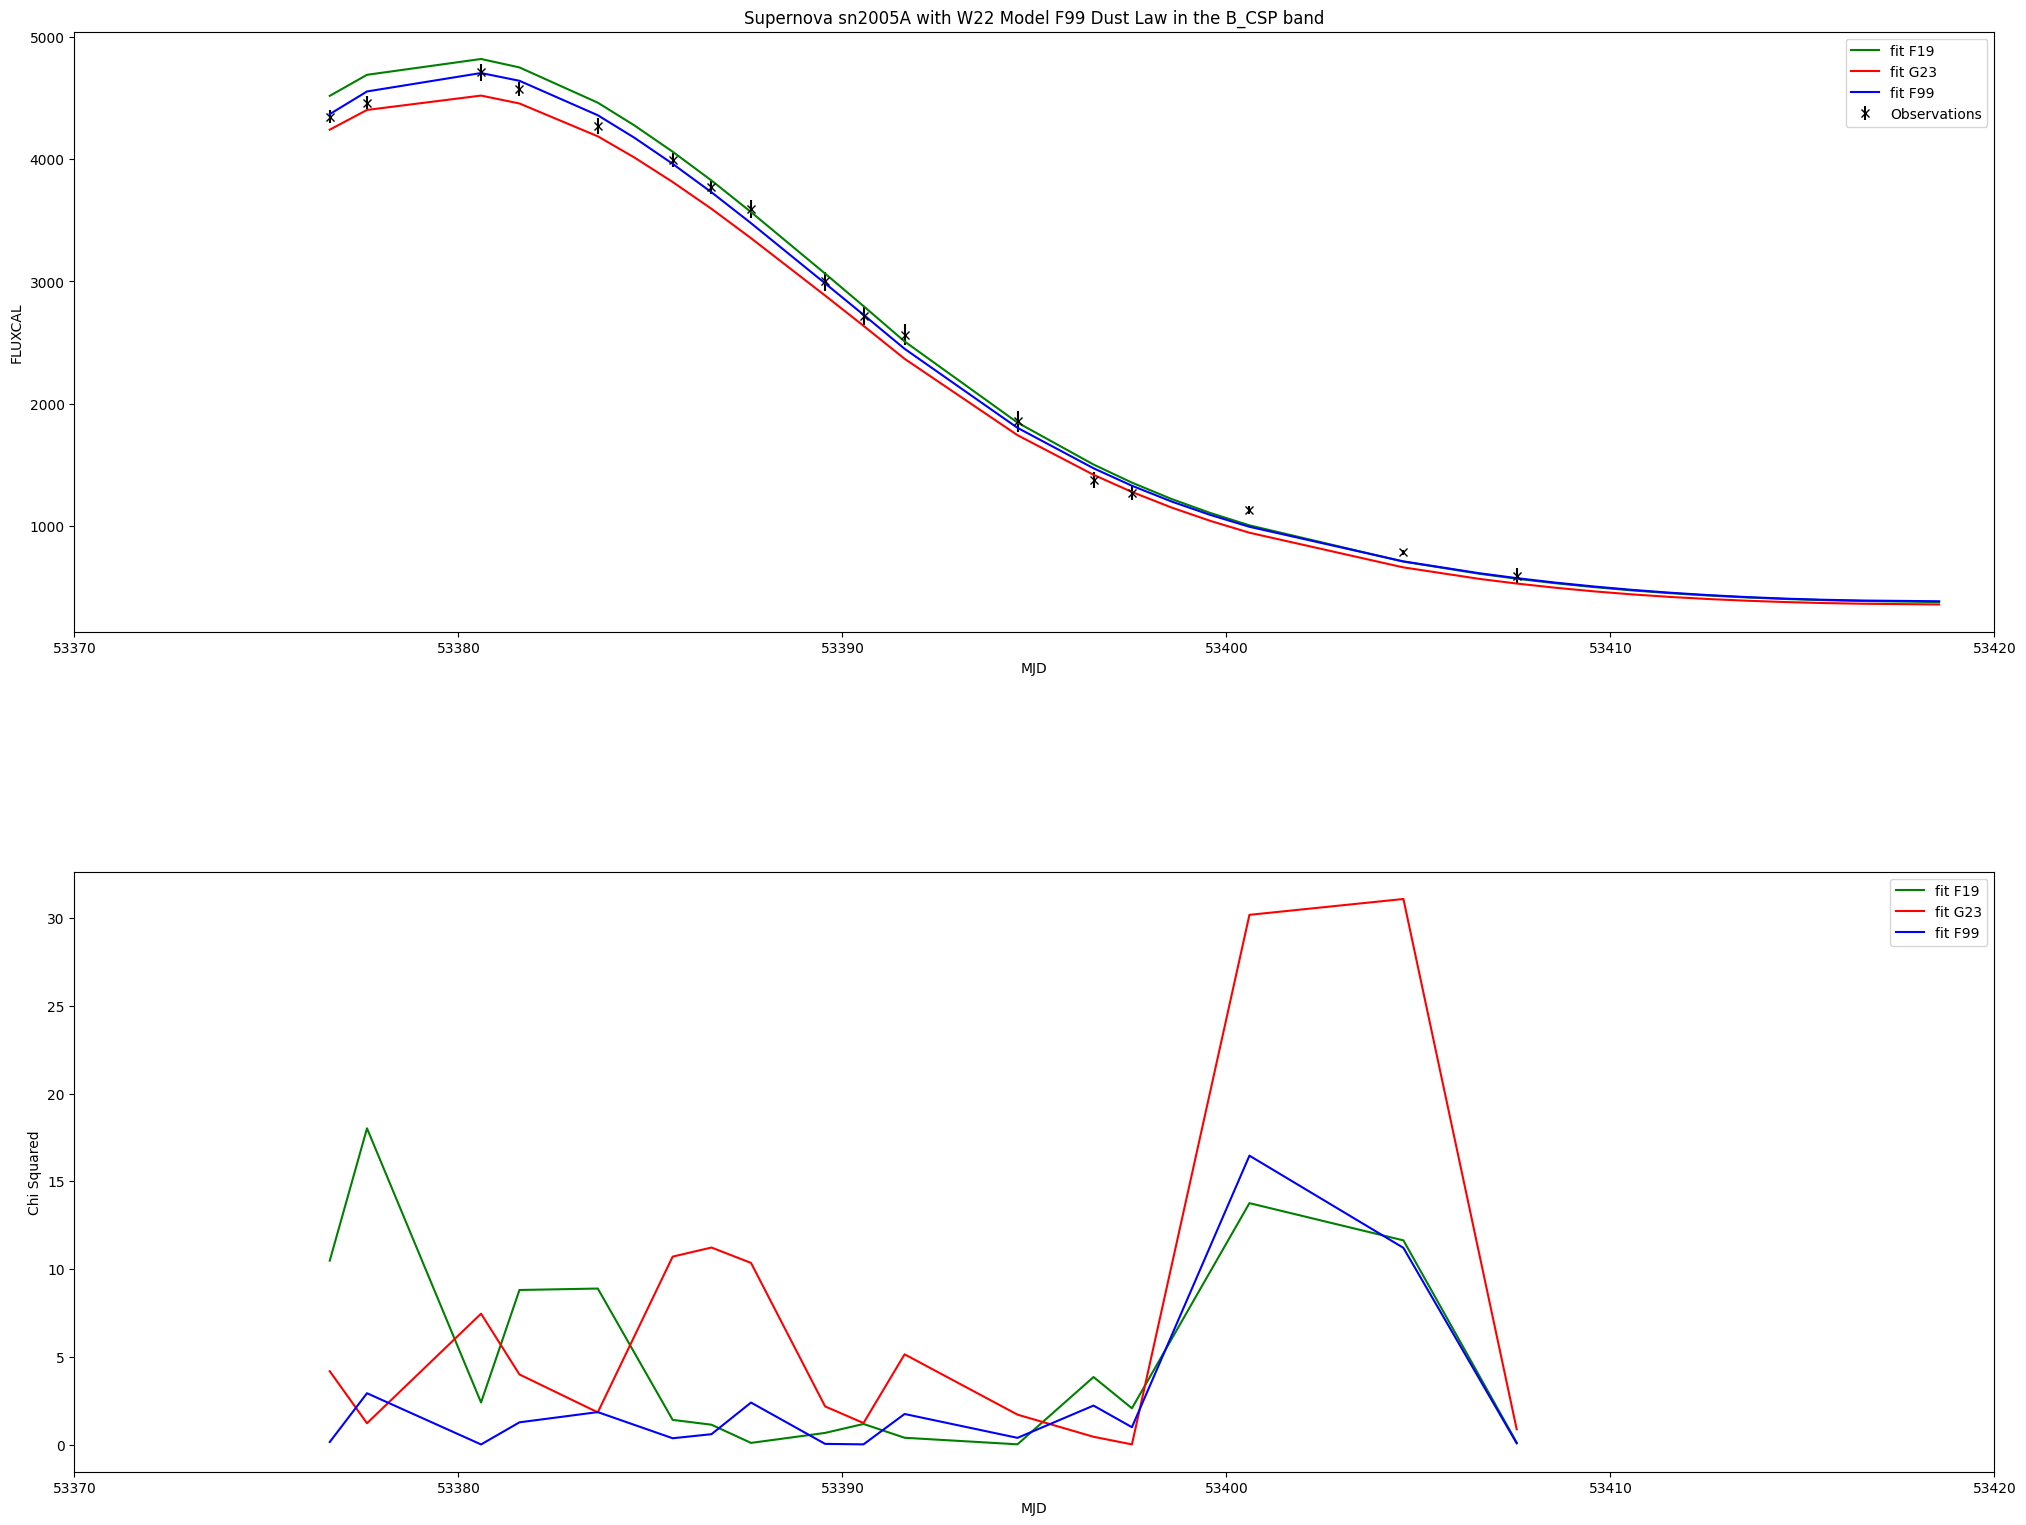

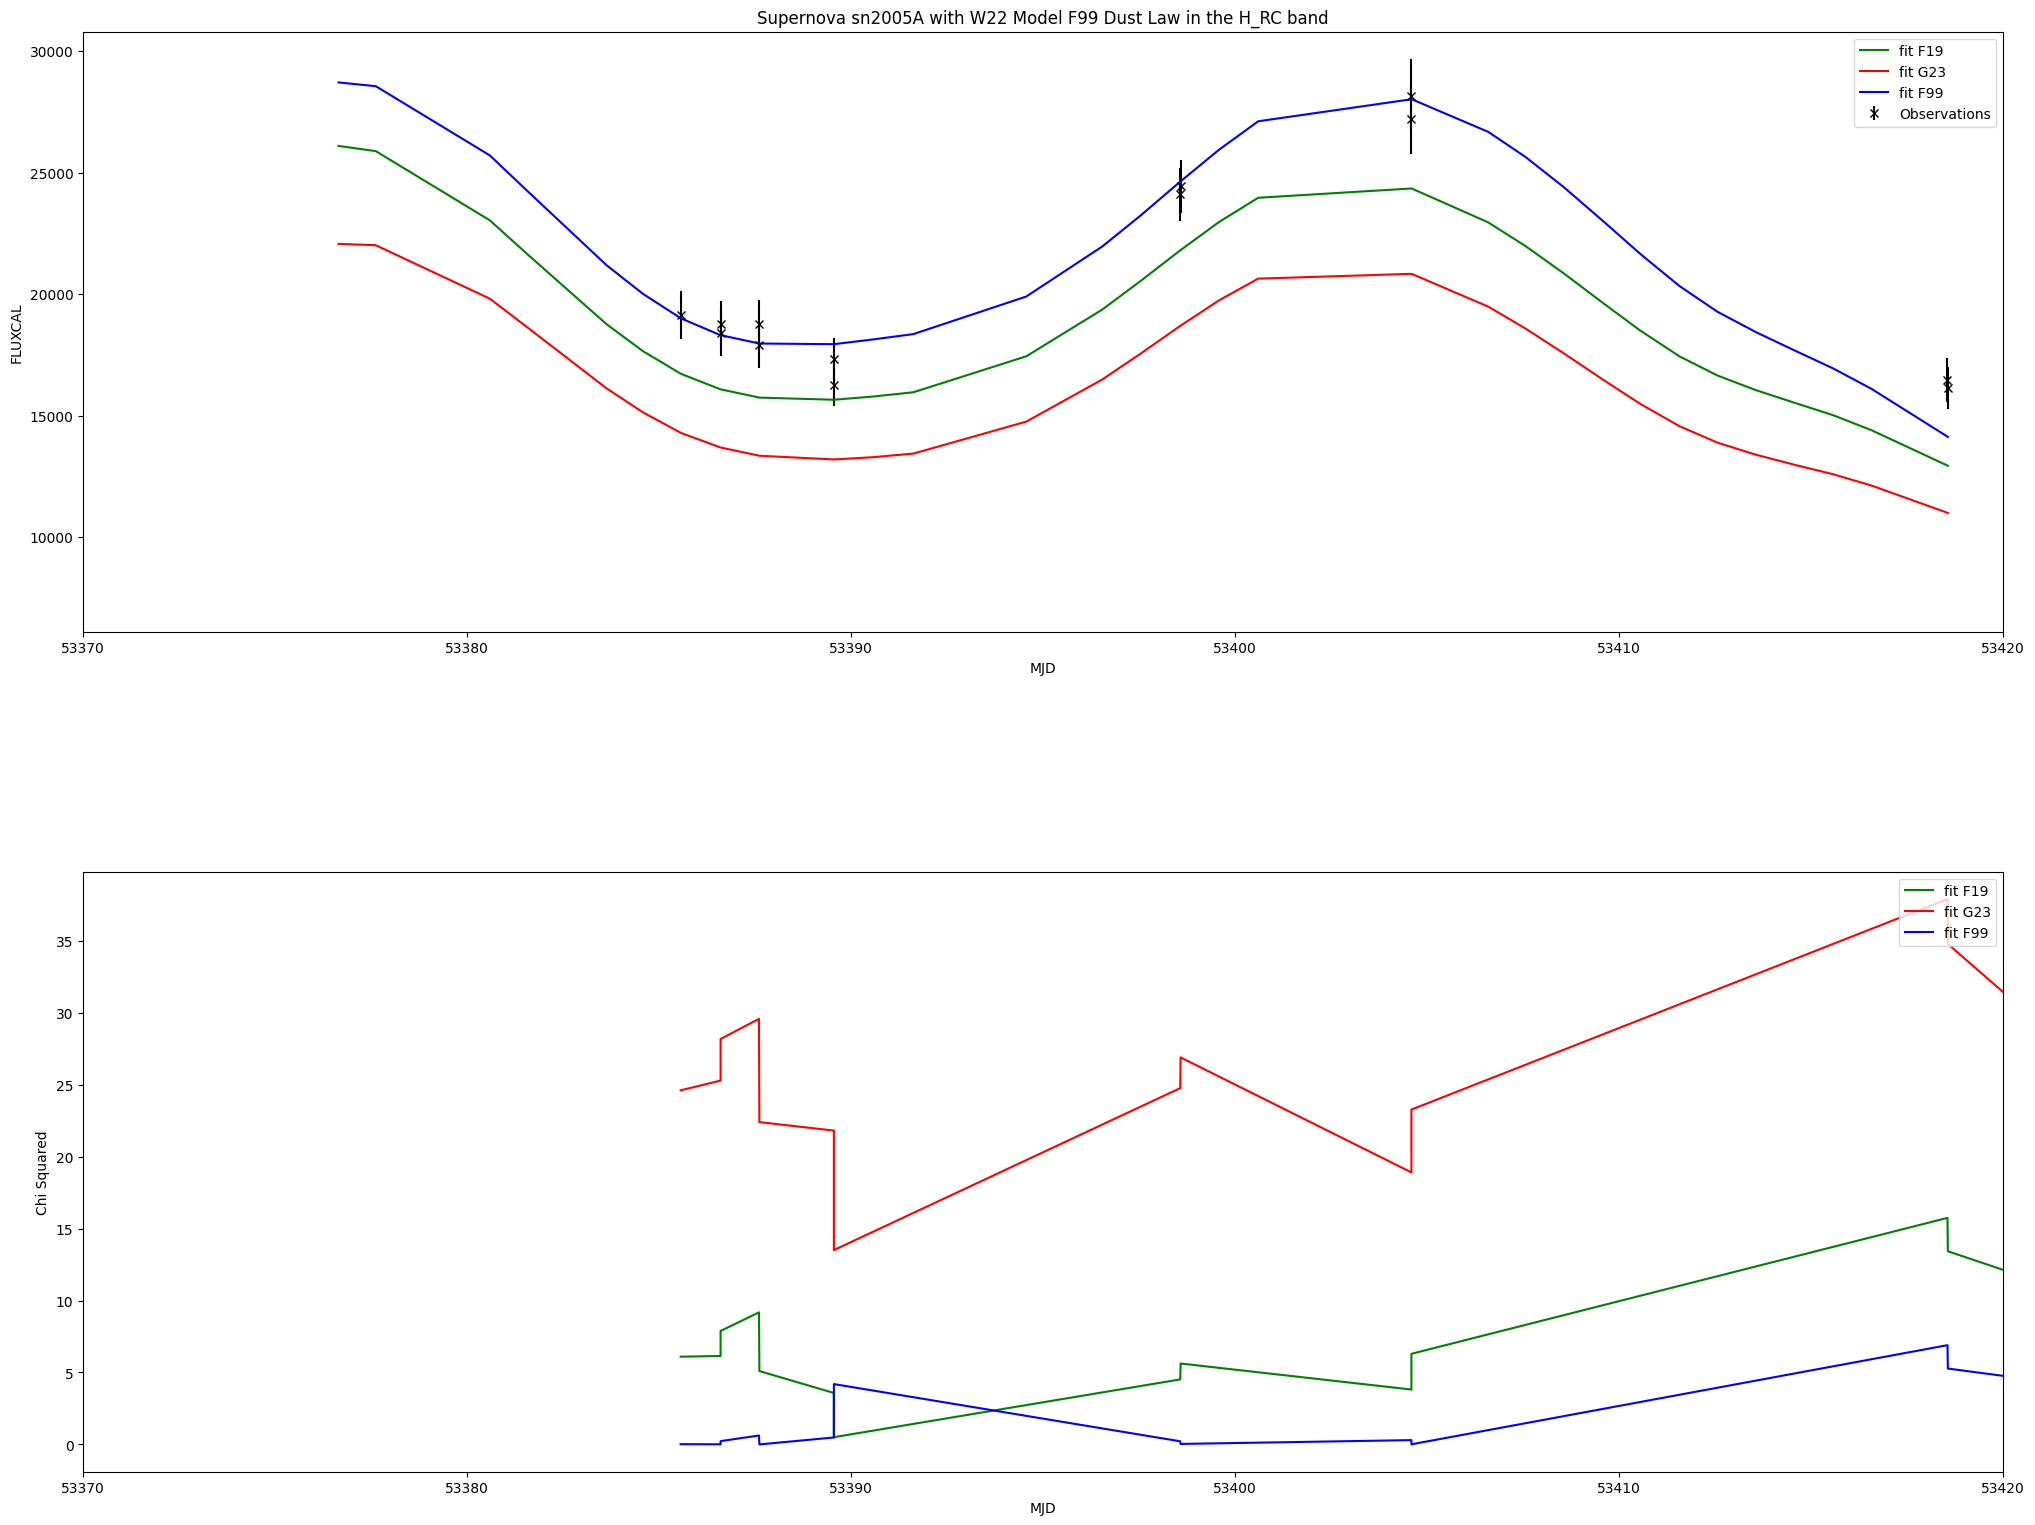

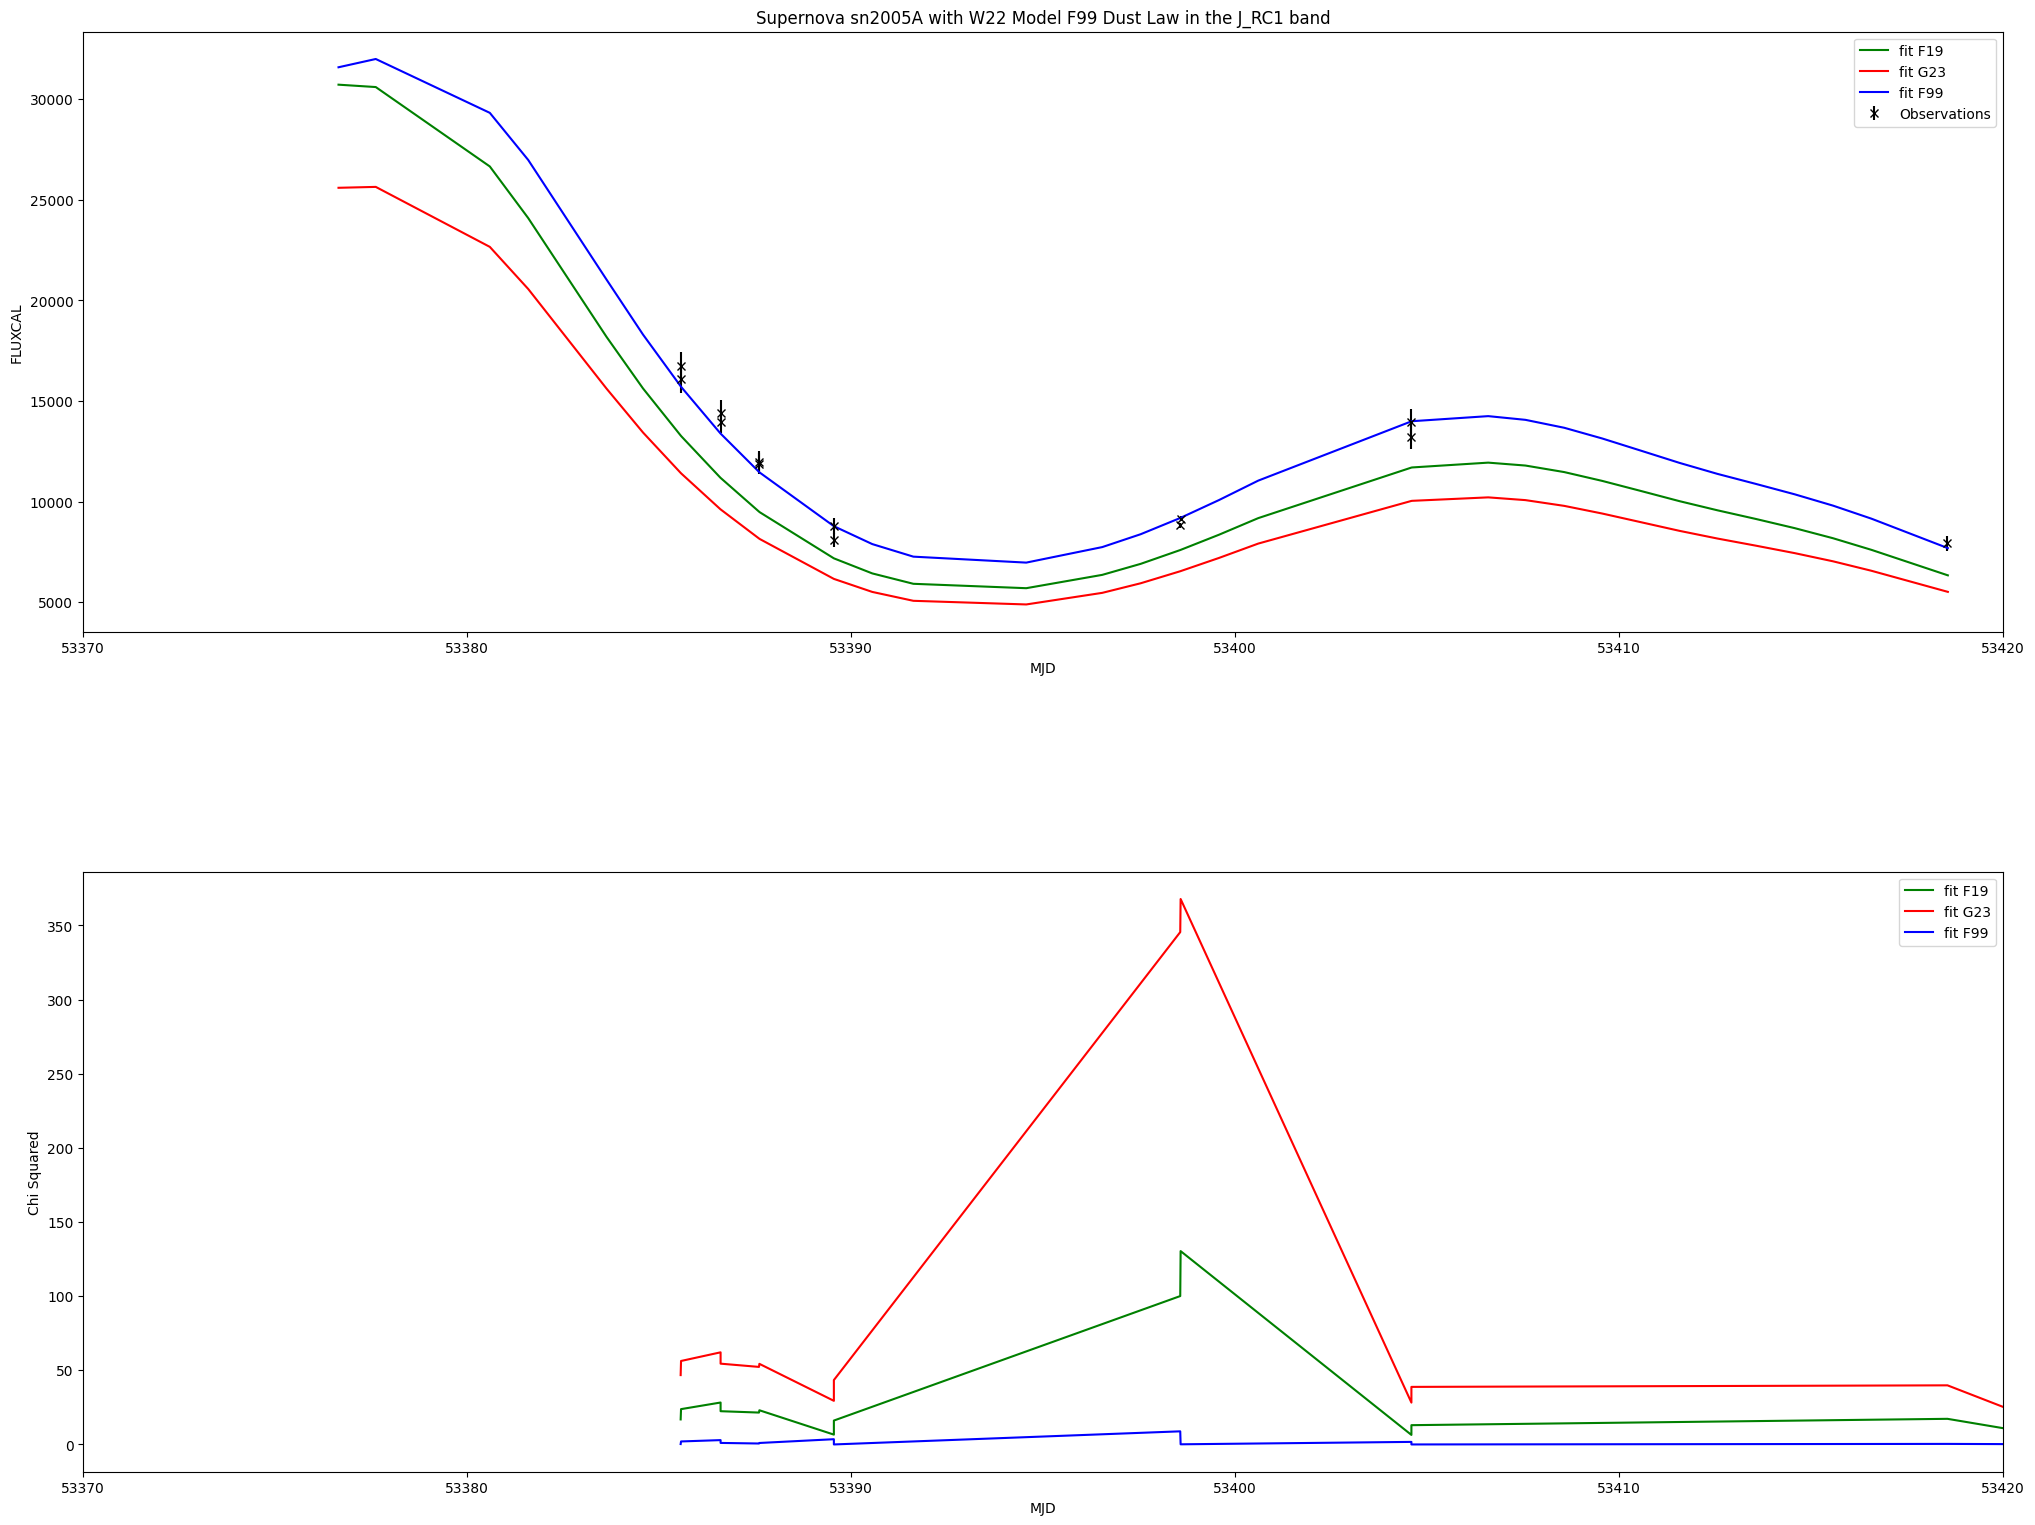

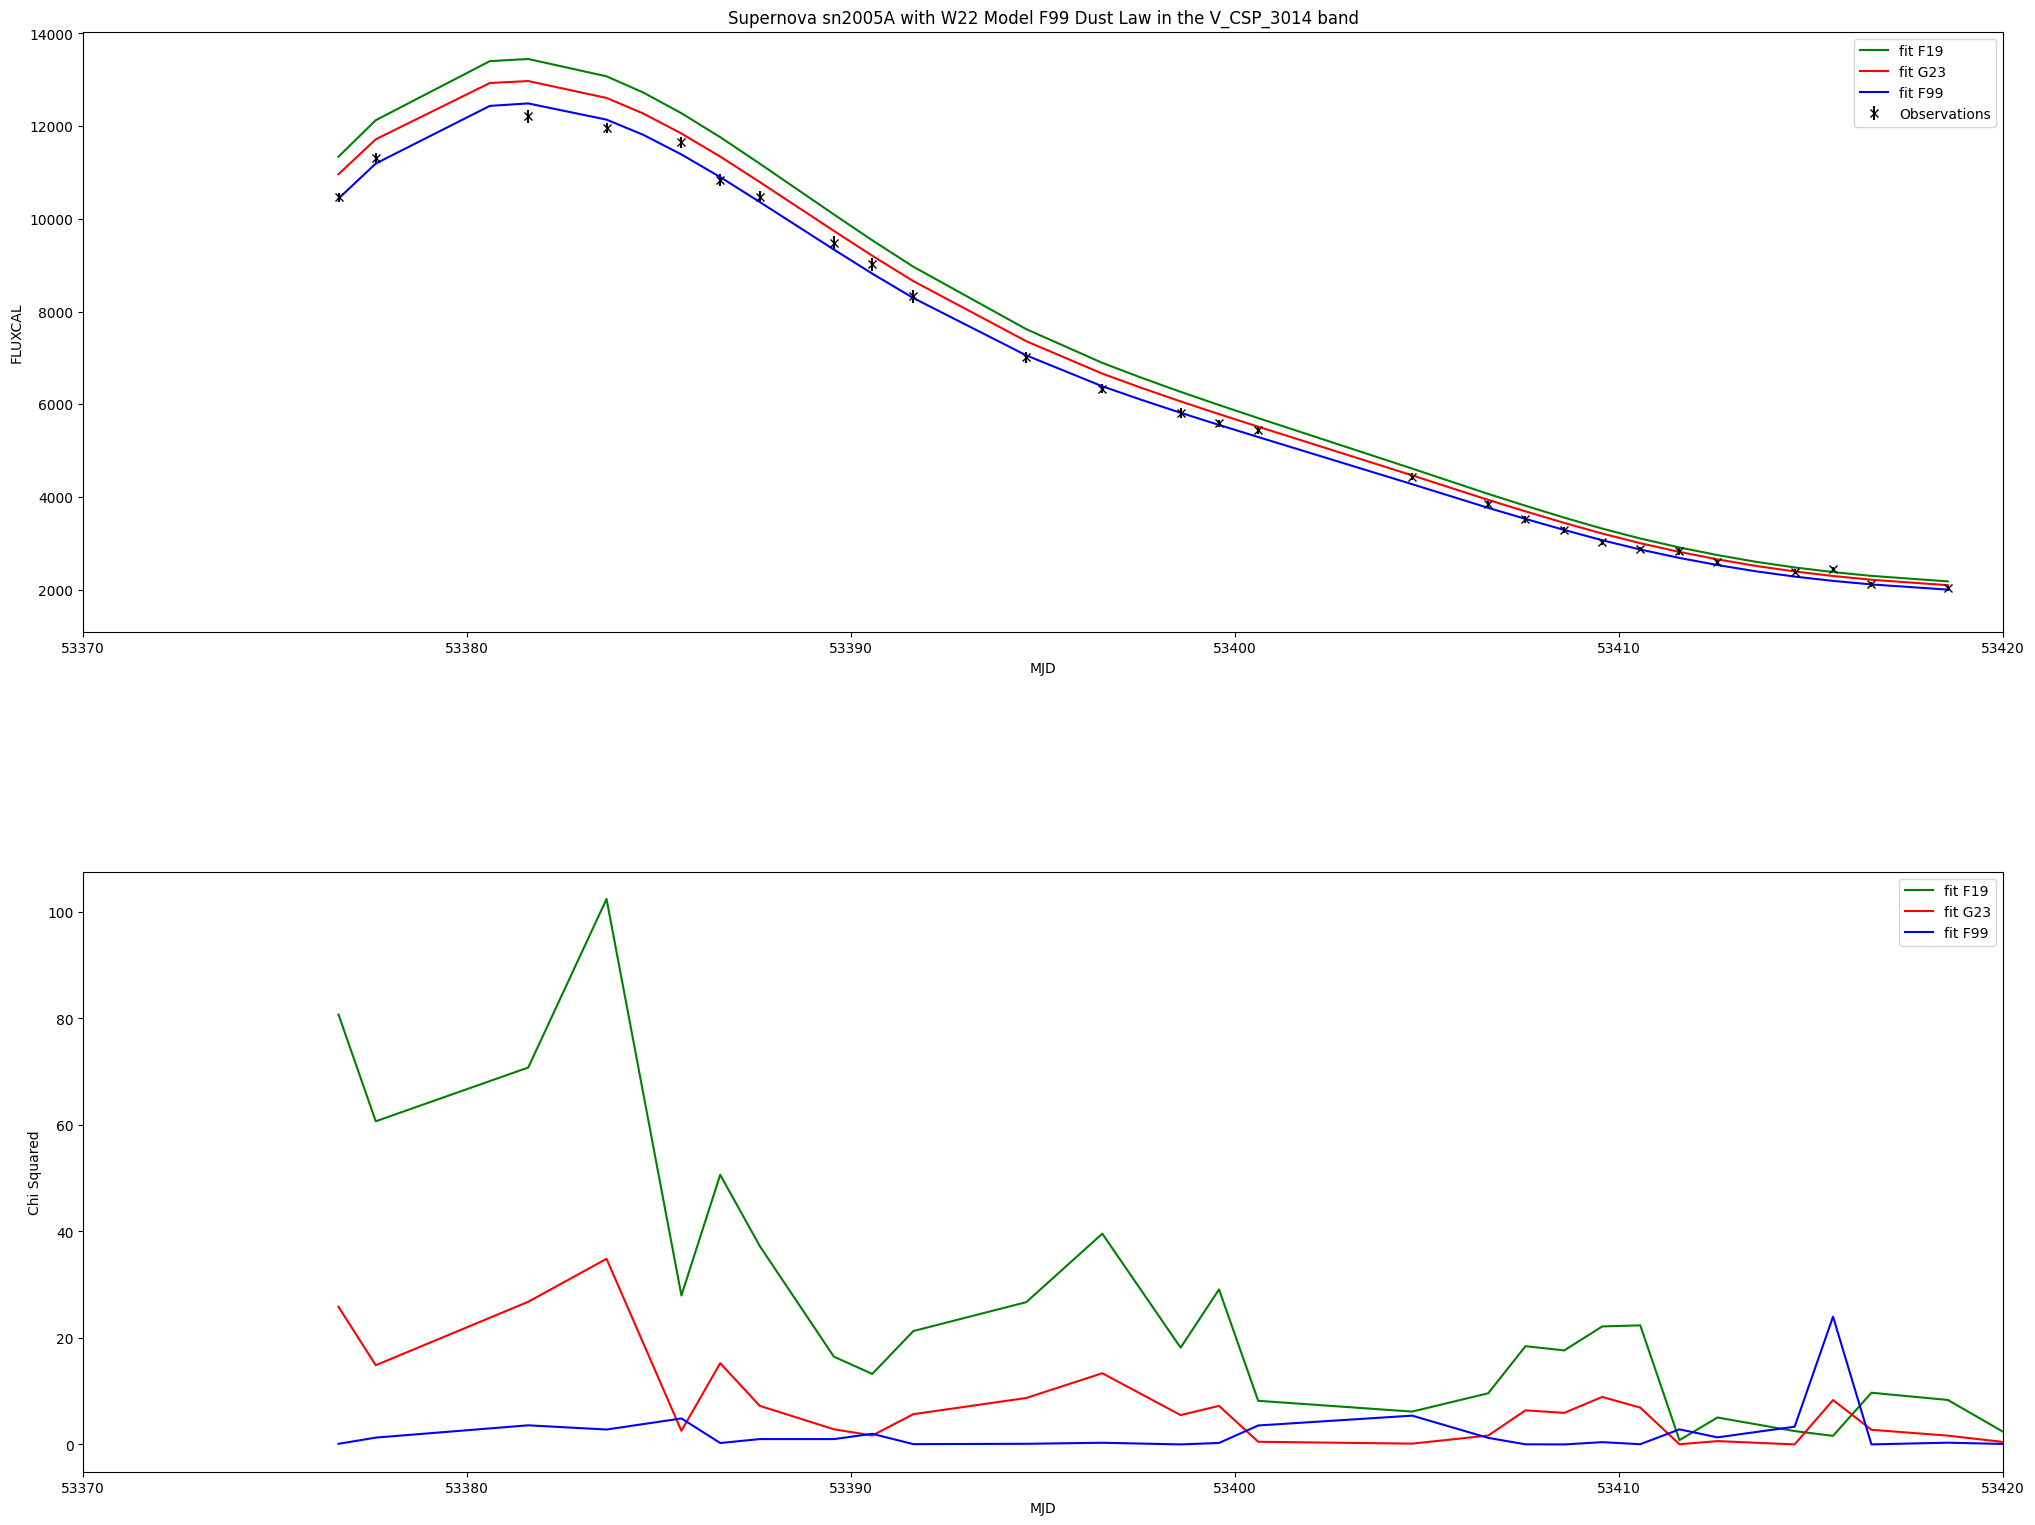

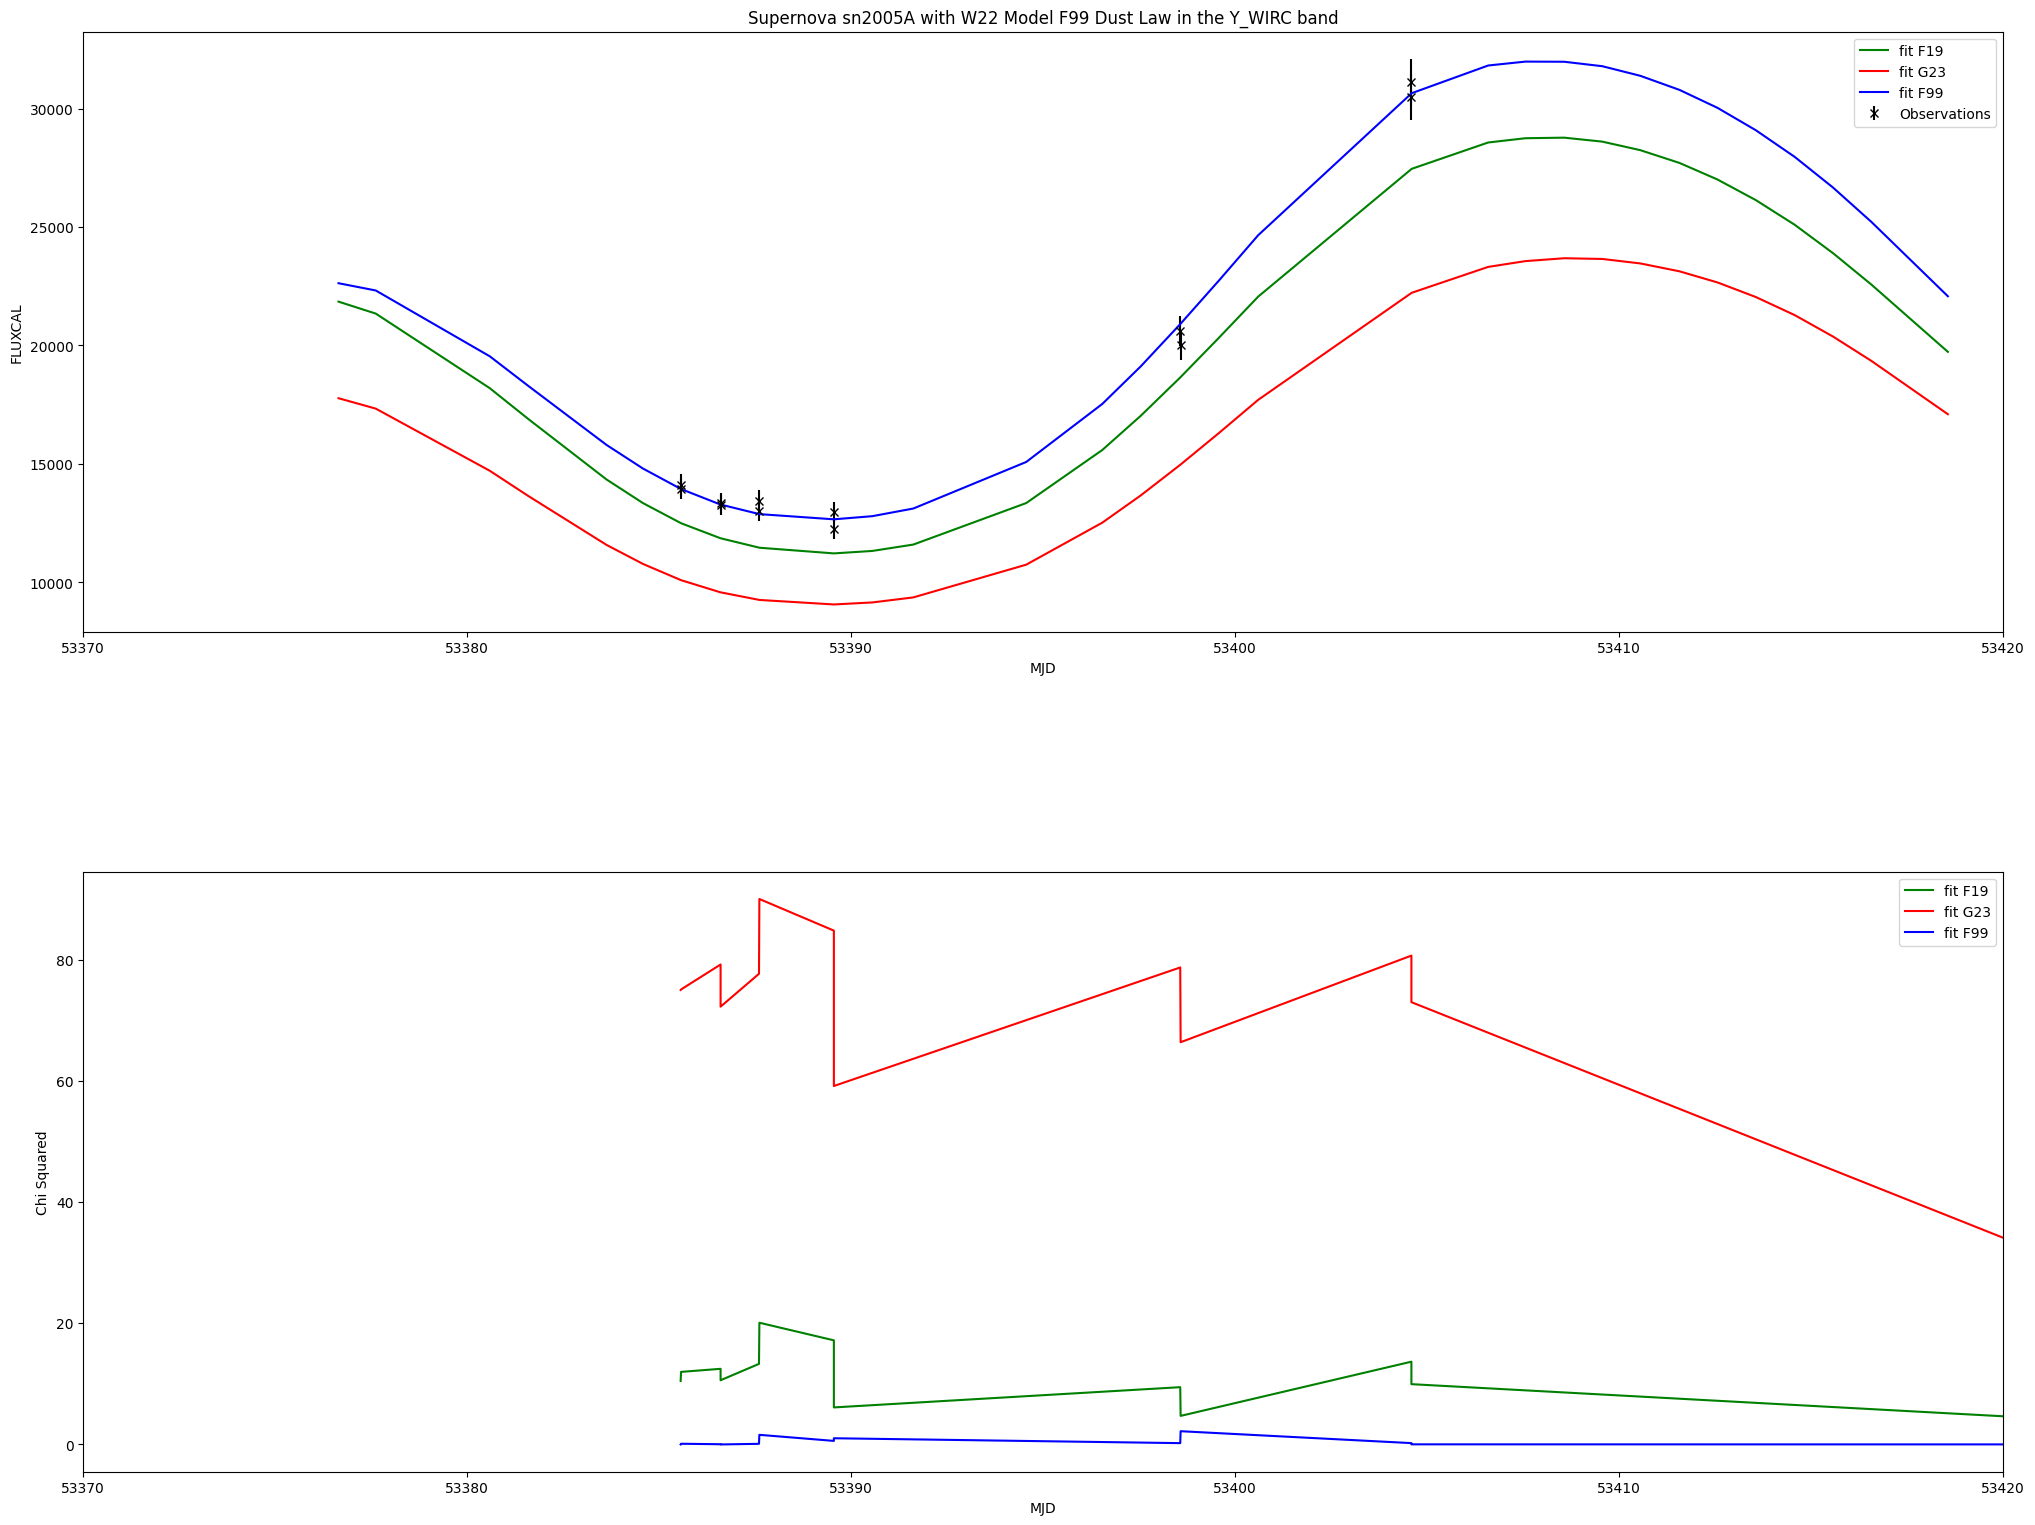

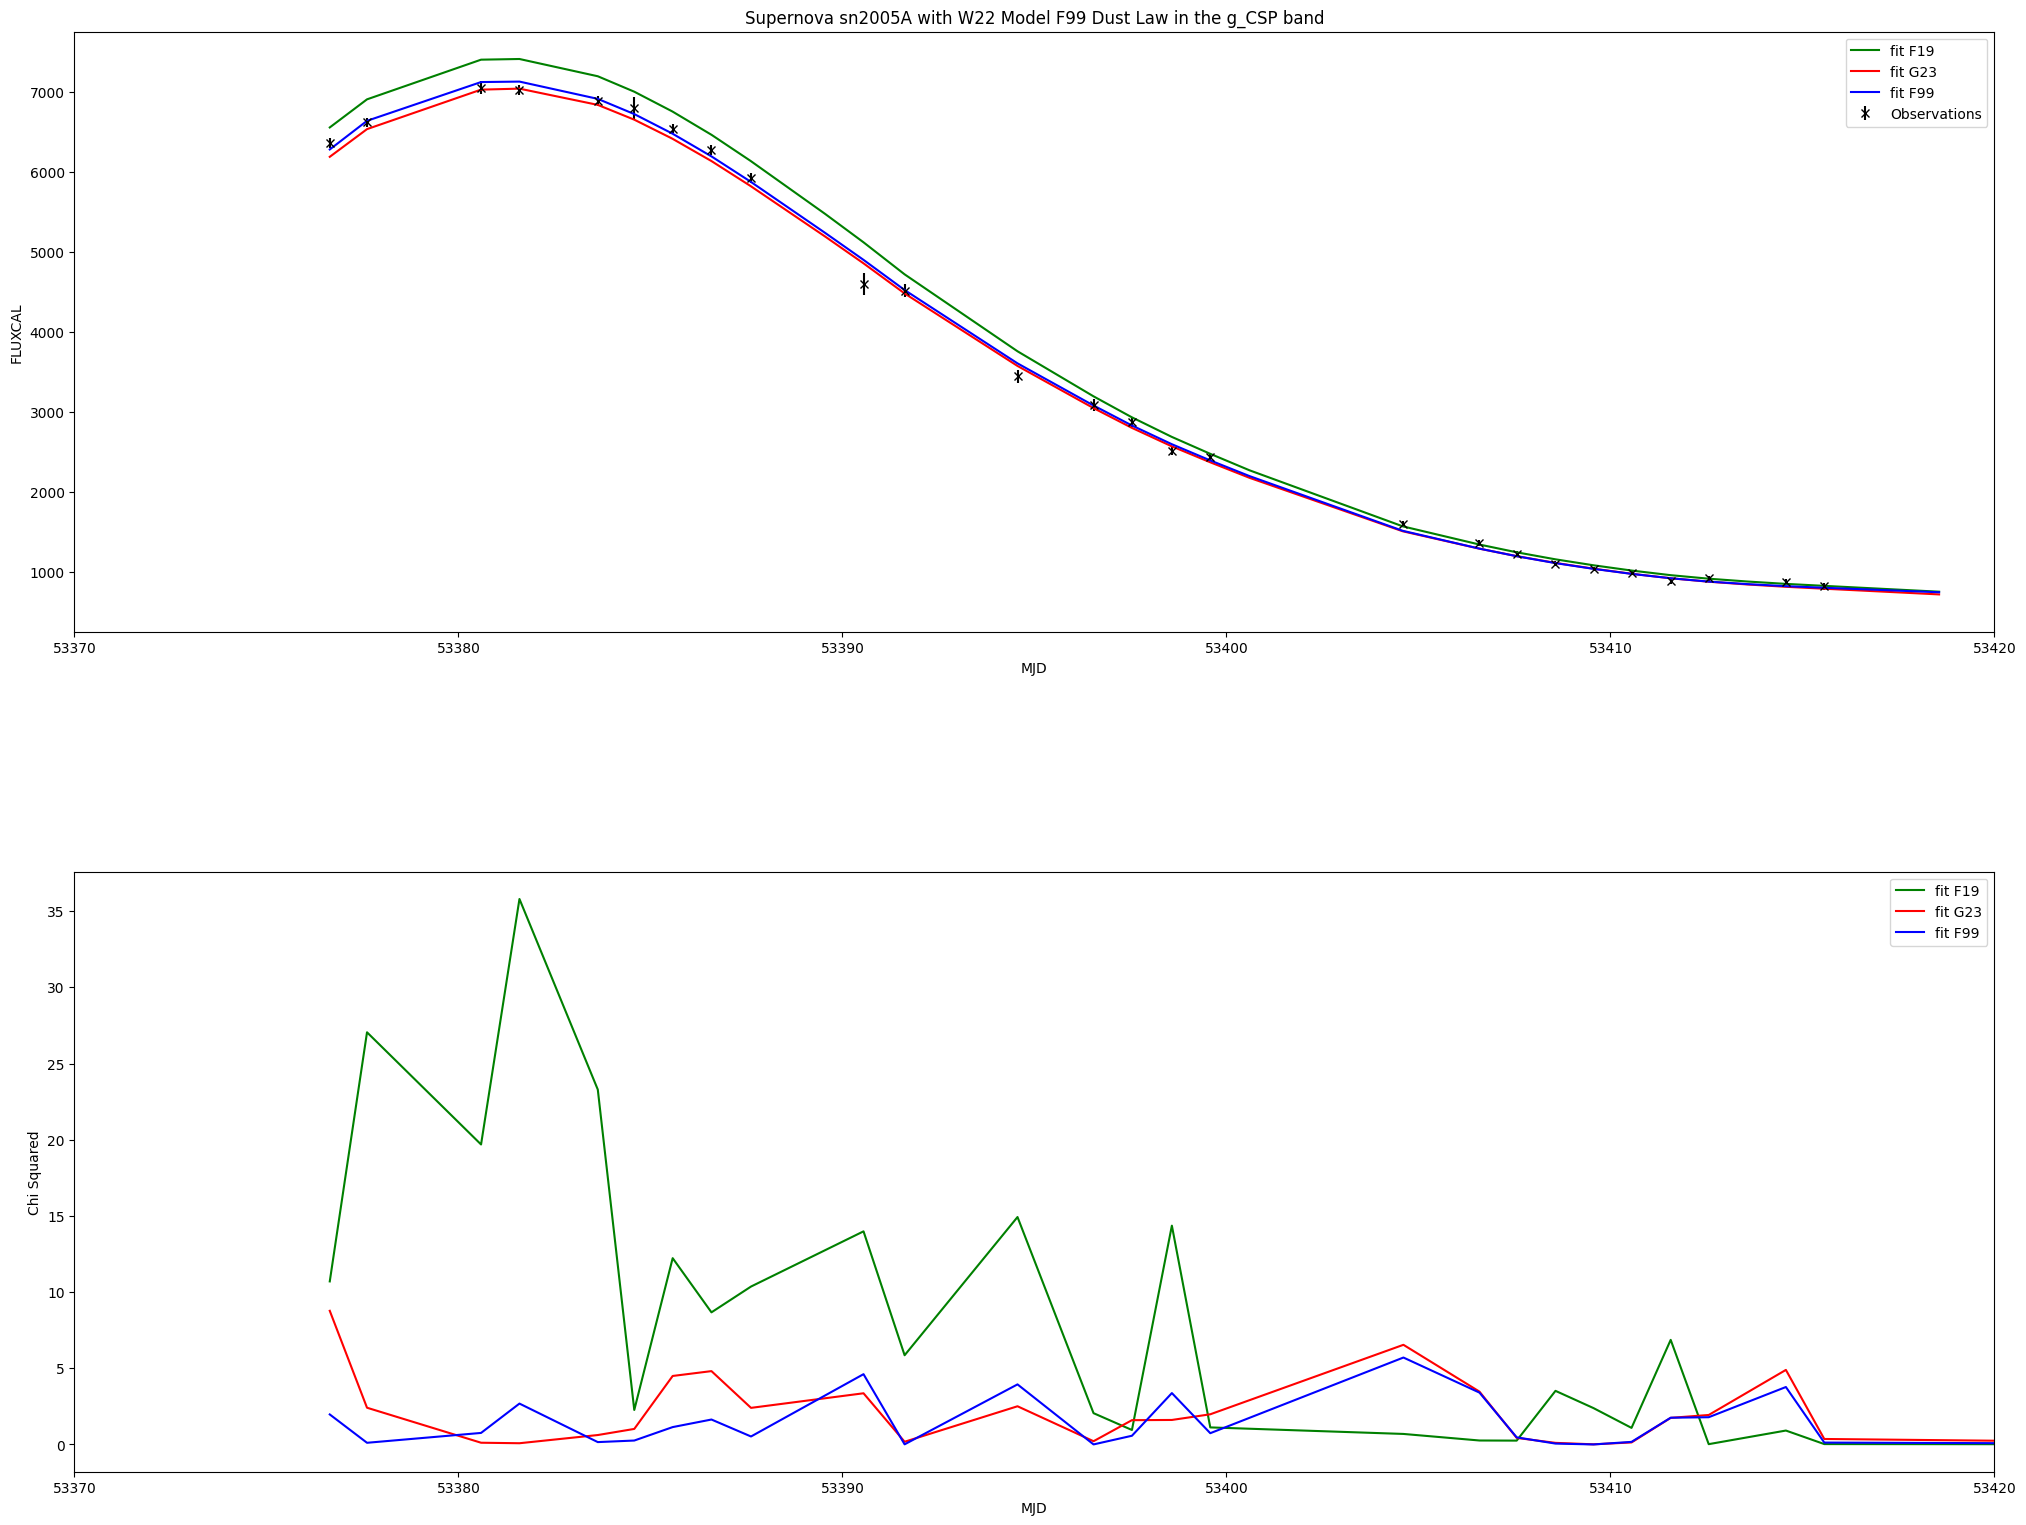

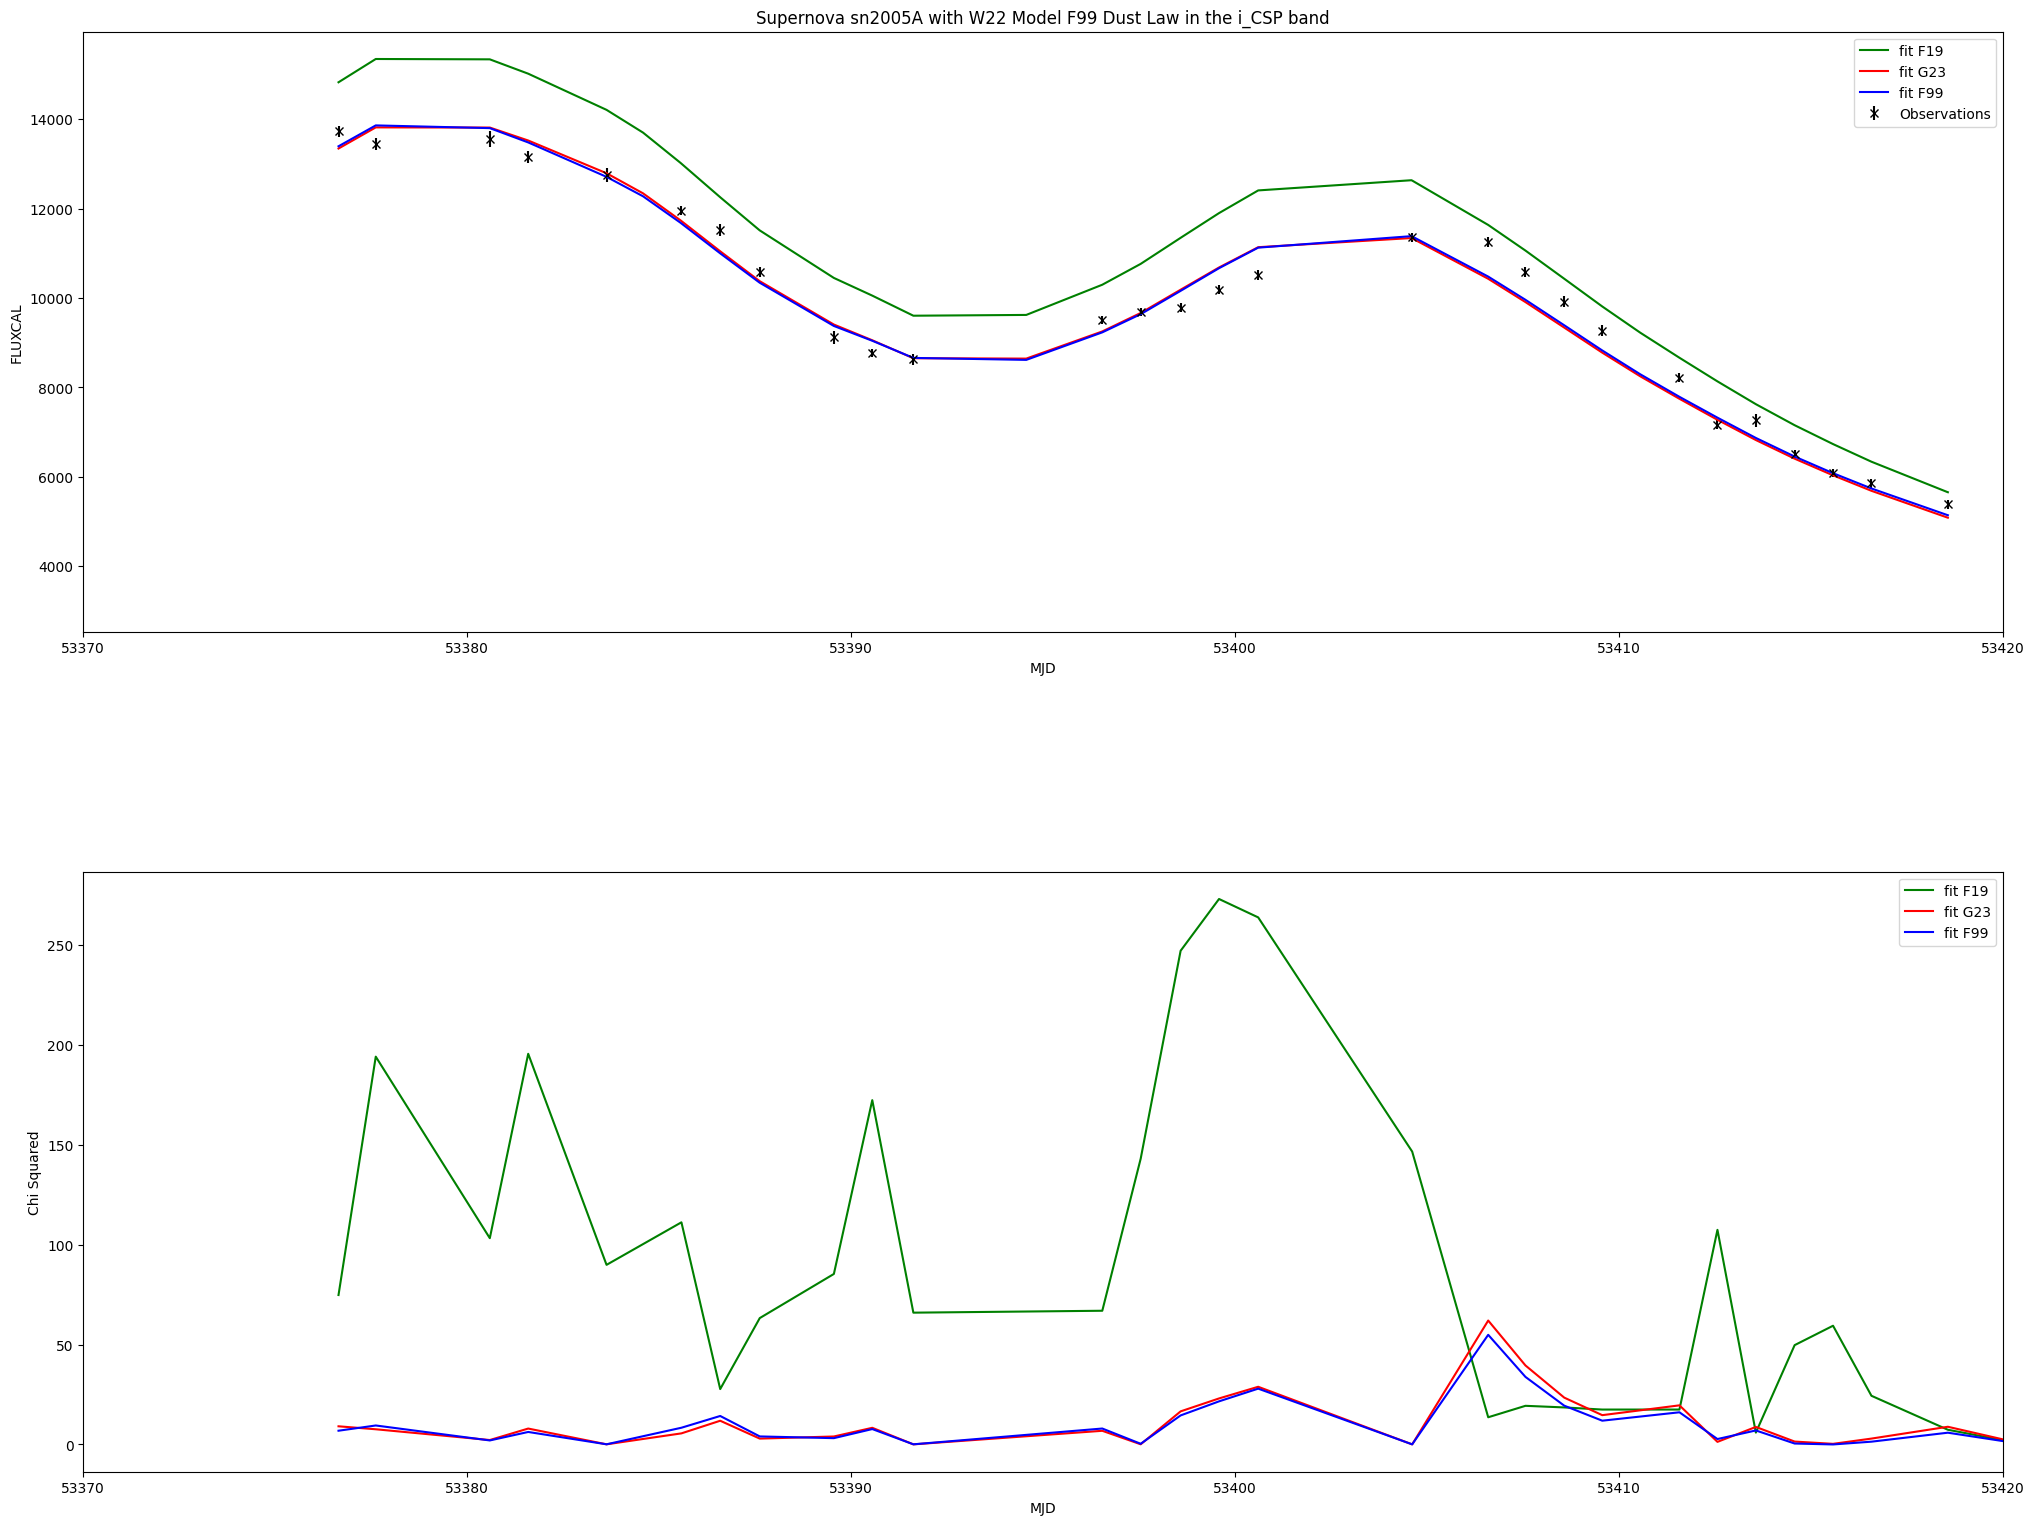

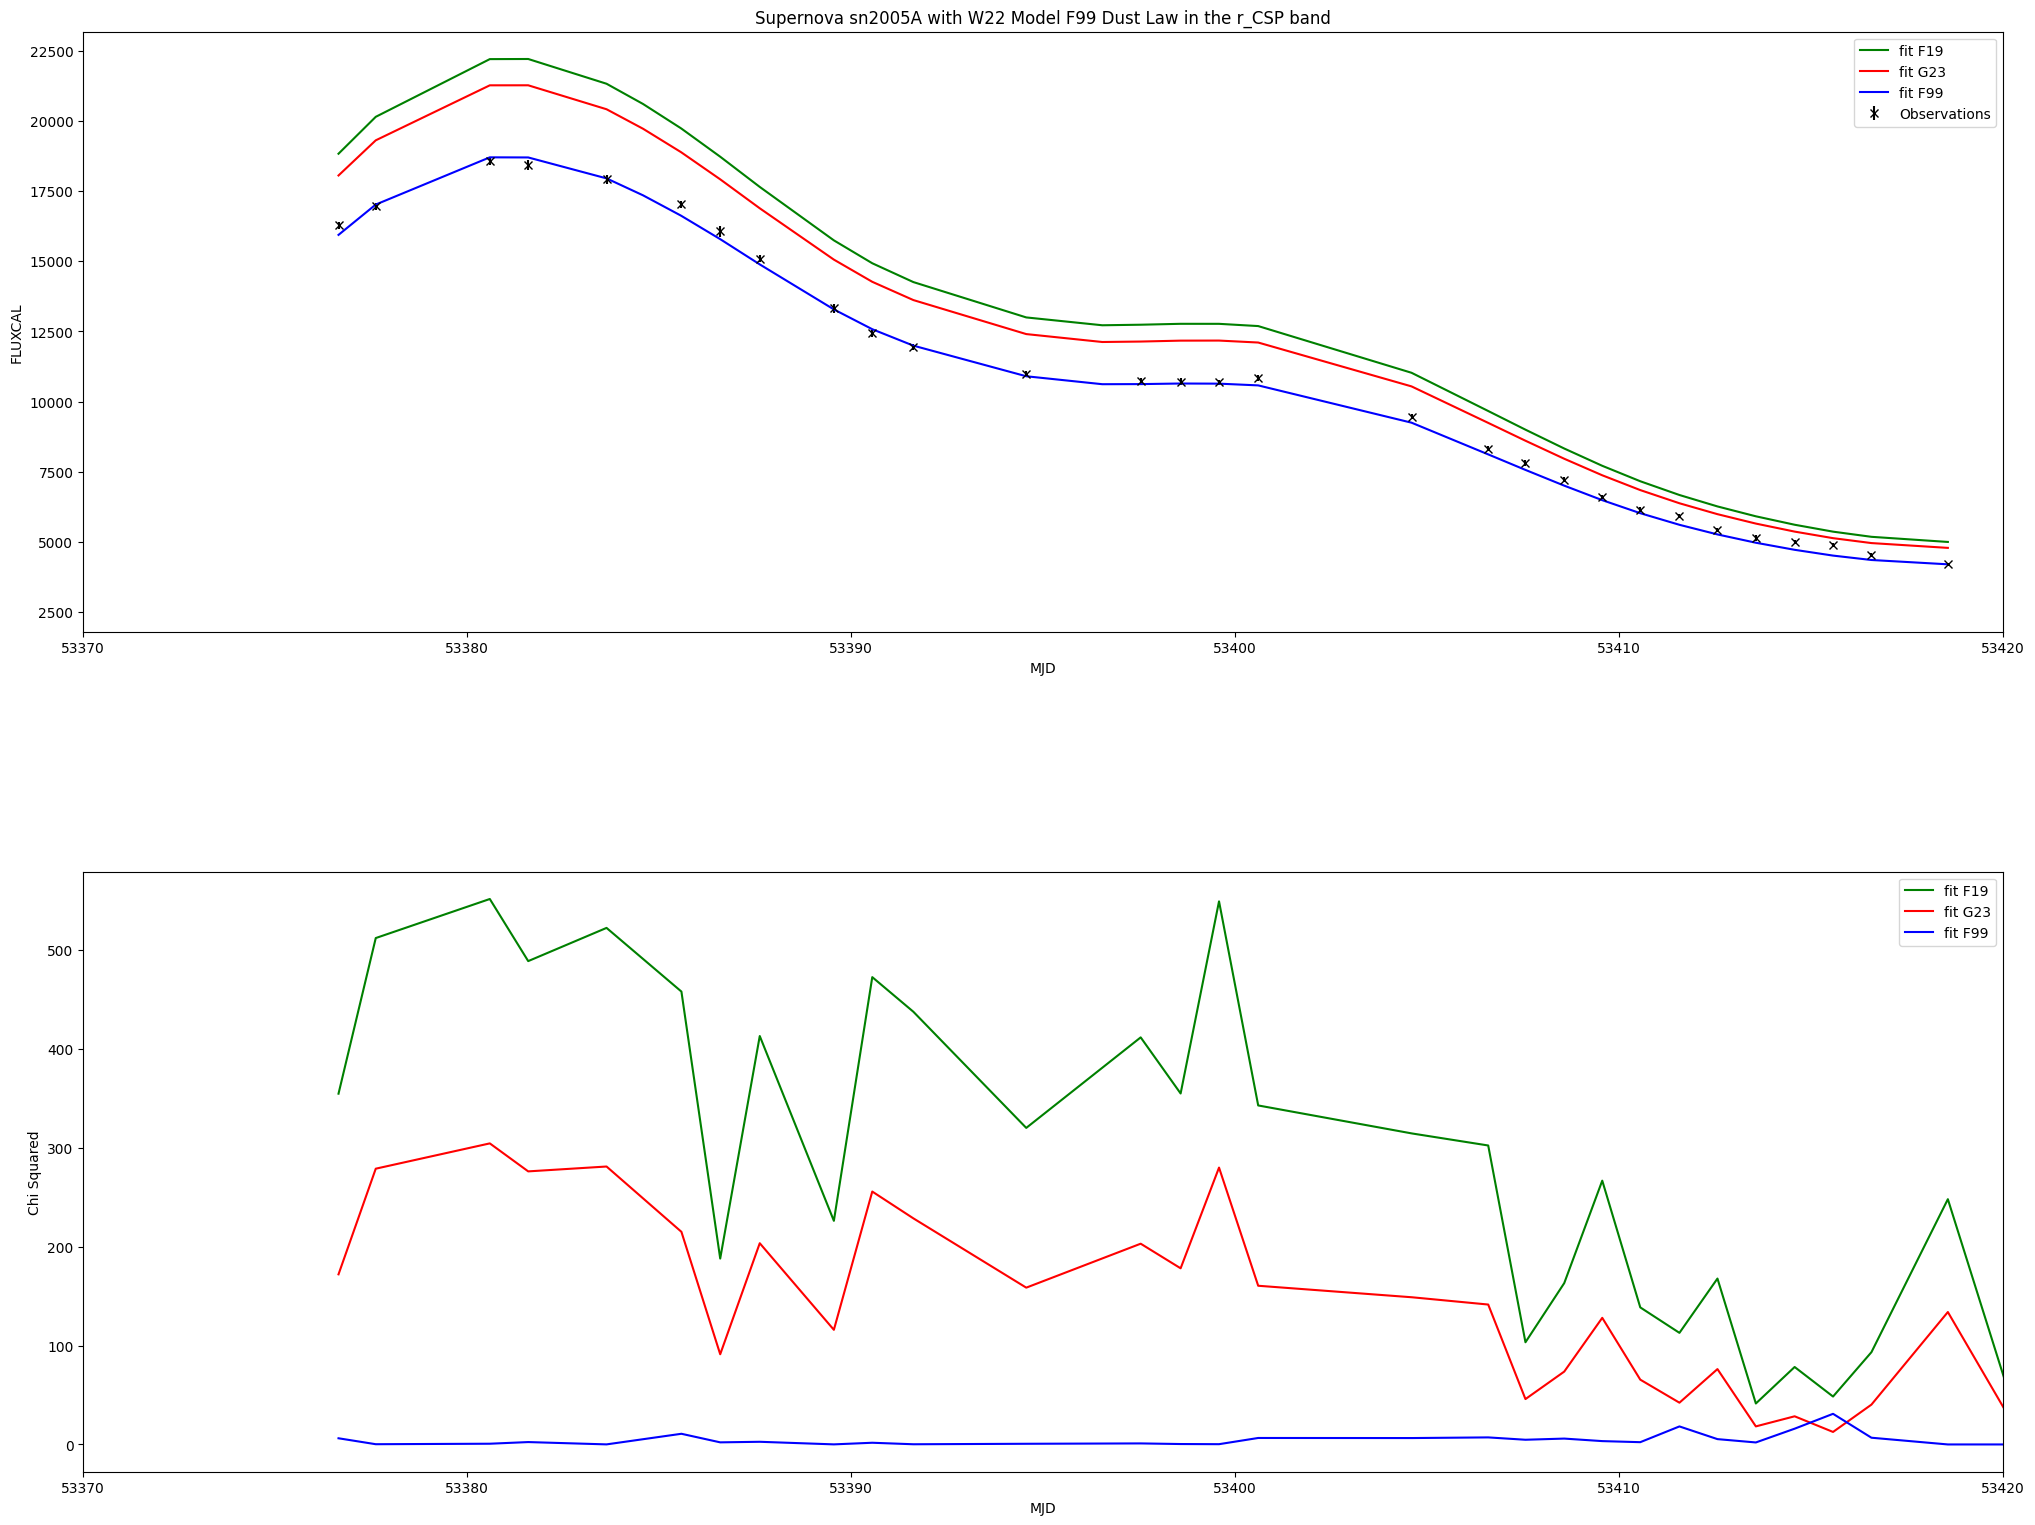

In [17]:
cs = ['g', 'r', 'b', 'c', 'm', 'y', 'k','g', 'y', 'b', 'c', 'm','k','g', 'r', 'b', 'c', 'm', 'y', 'k','g', 'y', 'b', 'c', 'm']
plot_t = t_obs + meta['SEARCH_PEAKMJD']

for b_ind, b in enumerate(bands):
    
    if b == 'u_CSP' or b == 'U':
        continue
    
    #Observed
    b_data = lcdata[lcdata.FLT == b]
    #plt.errorbar(b_data.MJD, b_data.FLUXCAL, b_data.FLUXCALERR, fmt=f'{cs[b_ind]}x', label=b)

    #From fit
    #plt.plot(plot_t, fit[b_ind, :], color=cs[b_ind])
    #plt.fill_between(plot_t, fit[b_ind, :] - fit_err[b_ind, :], fit[b_ind, :] + fit_err[b_ind, :], alpha=0.3, color=cs[b_ind])

    #From simulation 
    #plt.plot(t_obs+meta['SEARCH_PEAKMJD'], flux[b_ind,:], color=cs[b_ind], linestyle='dotted')

    figure, axis = plt.subplots(2, 1)

    axis[0].errorbar(b_data.MJD, b_data.FLUXCAL, b_data.FLUXCALERR, fmt=f'{cs[6]}x', label="Observations")
    axis[0].set_xlim([meta['SEARCH_PEAKMJD']-10, meta['SEARCH_PEAKMJD']+40])
    axis[0].set_xlabel('MJD')
    axis[0].set_ylabel('FLUXCAL')
    axis[0].set_title(rf'Supernova '+supernova_name+' with W22 Model '+dust_law+' Dust Law in the '+b+" band")

    #Plot all the simulations and fitted
    for method in methods:
        for dust_law_index, dust_law in enumerate(dust_laws):
            dust_law_index = dust_laws.index(dust_law)
            flux_to_plot = np.reshape(fluxesdf.at[method+dust_law, b],len(plot_t))
            axis[0].plot(plot_t, flux_to_plot, label = method+" "+dust_law, color=cs[dust_law_index])
    axis[0].legend(loc='upper right')
    
    indexes_for_bands = lcdata.index[lcdata.FLT == b].tolist()
    for method_index, method in enumerate(methods):
        for dust_law_index, dust_law in enumerate(dust_laws):
            axis[1].plot(b_data.MJD, chi_squared[indexes_for_bands, dust_law_index, method_index], label = method+" "+dust_law, color=cs[dust_law_index])
    axis[1].set_xlabel('MJD')
    axis[1].set_ylabel('Chi Squared')
    axis[1].set_xlim([meta['SEARCH_PEAKMJD']-10,meta['SEARCH_PEAKMJD']+40])
    axis[1].legend(loc='upper right')

    plt.subplots_adjust(left=0, right=3, bottom=0, top=3, wspace=0.2, hspace=0.4)
    figure.savefig("/root/partiiiproject/ChiSquaredBandPlots/"+supernova_name+dust_law+b+"bandChiSquaredComparison.png", bbox_inches='tight') 
    figure.show()
   